# Leios simulation analysis at tag `leios-2025w26`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: nine variants


In [2]:
label <- "Rust simulator, mini-mainnet, 100 tx/s, 315 kB/s IB throughput, 8 slot/stage, 2.5 EB/stage"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/praos/lifecycle.R")) {
    load(file="results/praos/lifecycle.R")
} else {
    lifecycle <- fread("results/praos/lifecycle.csv.gz", stringsAsFactors=TRUE)
    lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
    save(lifecycle, file="results/praos/lifecycle.R")
}
lifecycle %>% summary

 Simulator     Variant           Sharding     Kind            Item      
 Rust:60259   praos:60259   unsharded:60259   RB:   60   0      :    1  
                                              EB:    0   1      :    1  
                                              IB:    0   10     :    1  
                                              TX:60199   100    :    1  
                                                         1000   :    1  
                                                         10000  :    1  
                                                         (Other):60253  
    Size [B]         References     Created [s]     To IB [s]     
 Min.   :      8   Min.   :0.000   Min.   :  20.0   Mode:logical  
 1st Qu.:    438   1st Qu.:1.000   1st Qu.: 209.9   NA's:60259    
 Median :    935   Median :1.000   Median : 359.1                 
 Mean   :   4410   Mean   :1.572   Mean   : 359.9                 
 3rd Qu.:   2008   3rd Qu.:2.000   3rd Qu.: 508.7                 
 Max.   :62921

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 1200

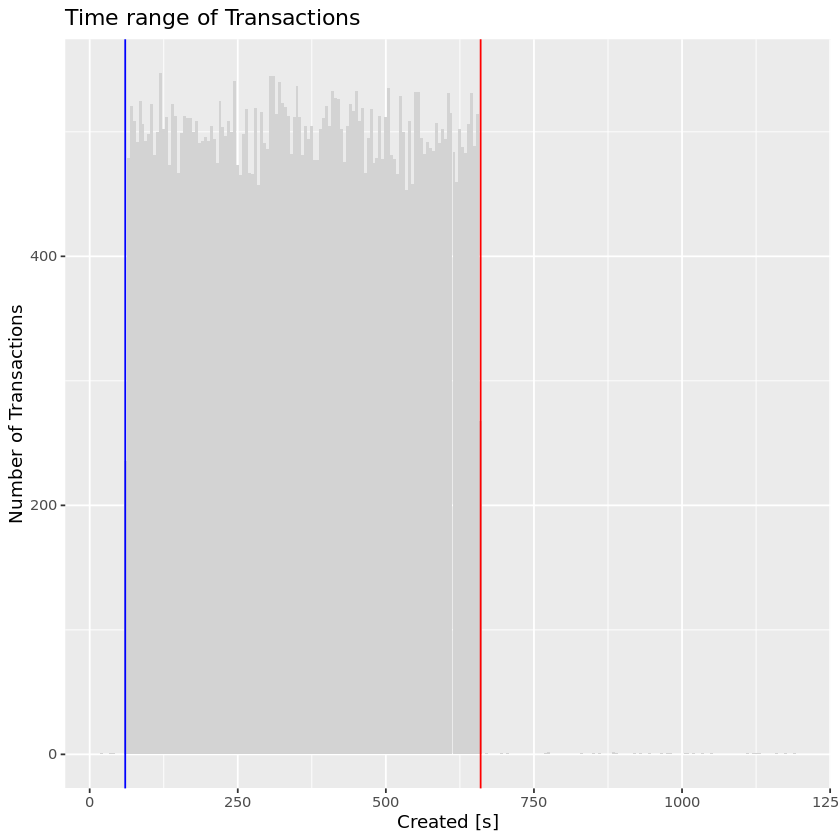

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [RB]`=sum(`Size [B]`)/txWindow/6291456/0.05
    ),
    .(`Variant`, `Sharding`)
]

Variant,Sharding,Demand [tx/s],Demand [MB/s],Demand [RB]
<fct>,<fct>,<dbl>,<dbl>,<dbl>
praos,unsharded,100.3317,0.1715755,0.5454237


#### Size of persisted data

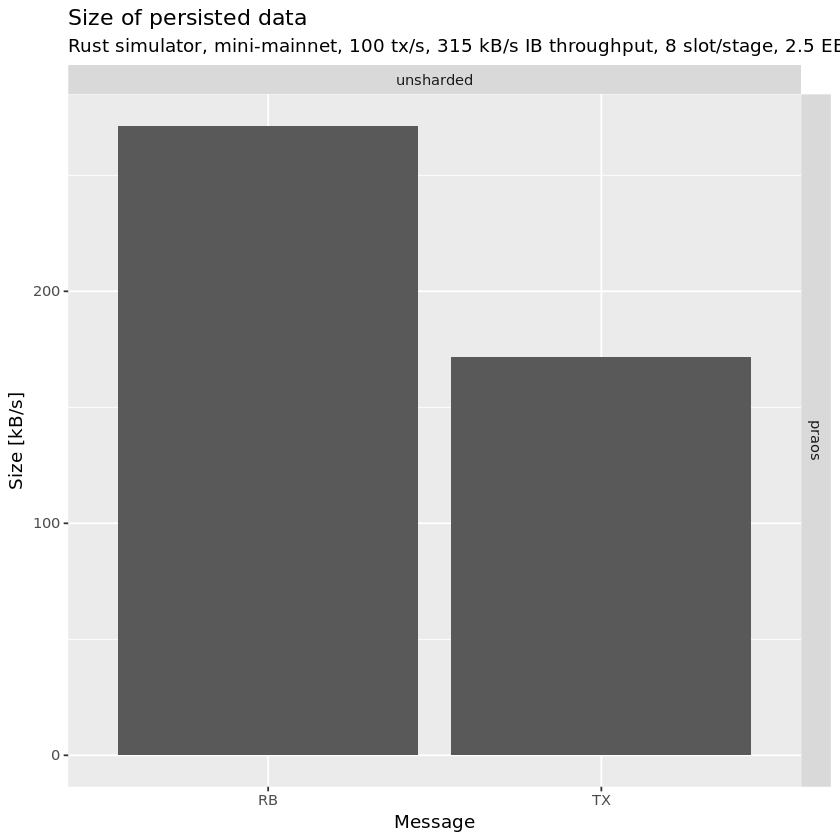

In [7]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Variant`, `Sharding`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_grid(`Variant` ~ `Sharding`, scales="fixed") +
    ggtitle("Size of persisted data", subtitle=label)

In [8]:
ggsave("plots/praos/sizes.png", units="in", dpi=150, width=8, height=6)

In [9]:
ggsave("plots/praos/sizes.svg", units="in", dpi=150, width=8, height=6)

#### References

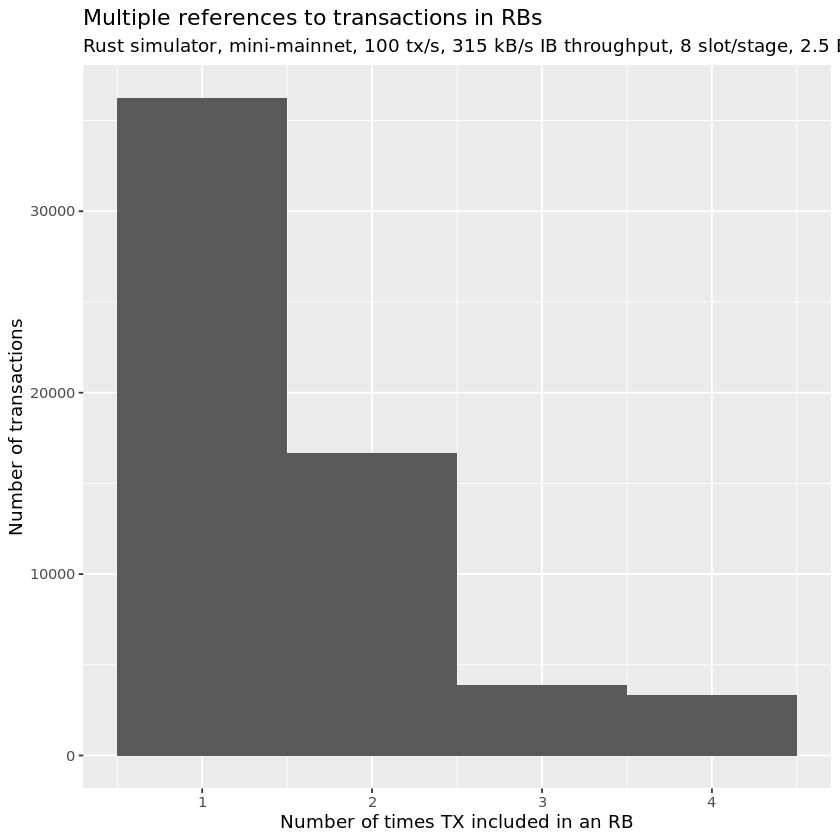

In [10]:
ggplot(lifecycle[`Kind` == "TX"], aes(x=`References`)) +
    geom_histogram(binwidth=1) +
    xlab("Number of times TX included in an RB") +
    ylab("Number of transactions") +
    ggtitle("Multiple references to transactions in RBs", subtitle=label)

In [11]:
ggsave("plots/praos/refrences.png", units="in", dpi=150, width=8, height=6)

In [12]:
ggsave("plots/praos/references.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

In [13]:
lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Sharding`)
    ][
        lifecycle[
            `Kind` == "RB", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Variant`, `Sharding`)
        ],
        on=c("Variant", "Sharding")
    ][, .(`Variant`, `Sharding`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)]

Variant,Sharding,Space efficiency [%]
<fct>,<fct>,<dbl>
praos,unsharded,63.23253


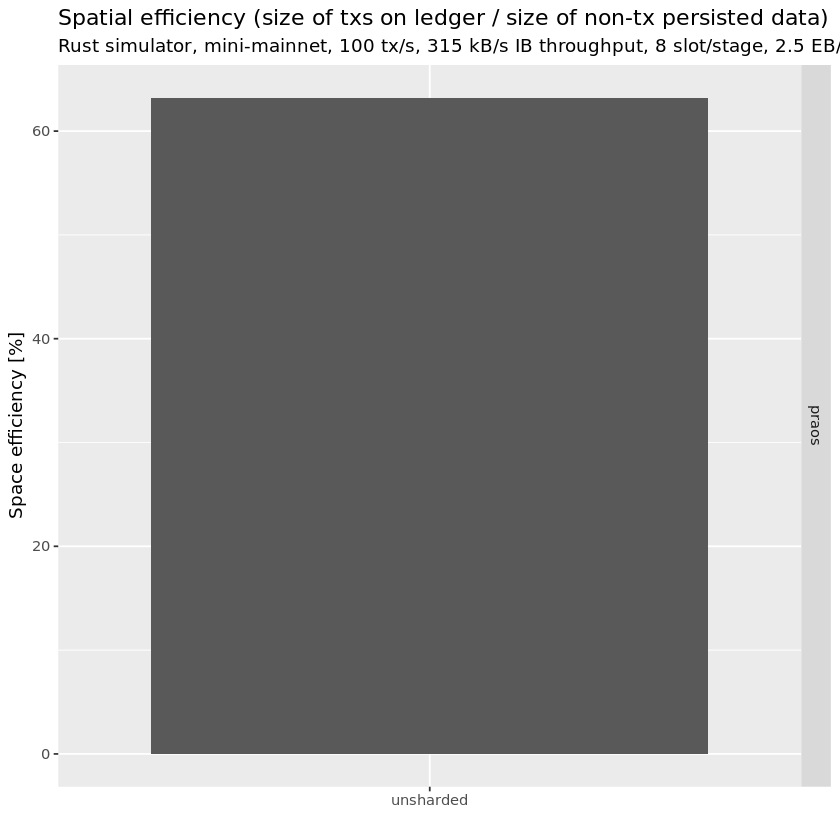

In [14]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Sharding`)
    ][
        lifecycle[
            `Kind` == "RB", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Variant`, `Sharding`)
        ],
        on=c("Variant", "Sharding")
    ][, .(`Variant`, `Sharding`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Sharding`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Variant` ~ .) +
    xlab("") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [15]:
ggsave("plots/praos/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [16]:
ggsave("plots/praos/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

In [17]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`In RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`In RB [s]`-`Created [s]`)), 
        .(`Variant`, `Sharding`)
    ]

Variant,Sharding,Time to reach ledger [s]
<fct>,<fct>,<dbl>
praos,unsharded,38.76005


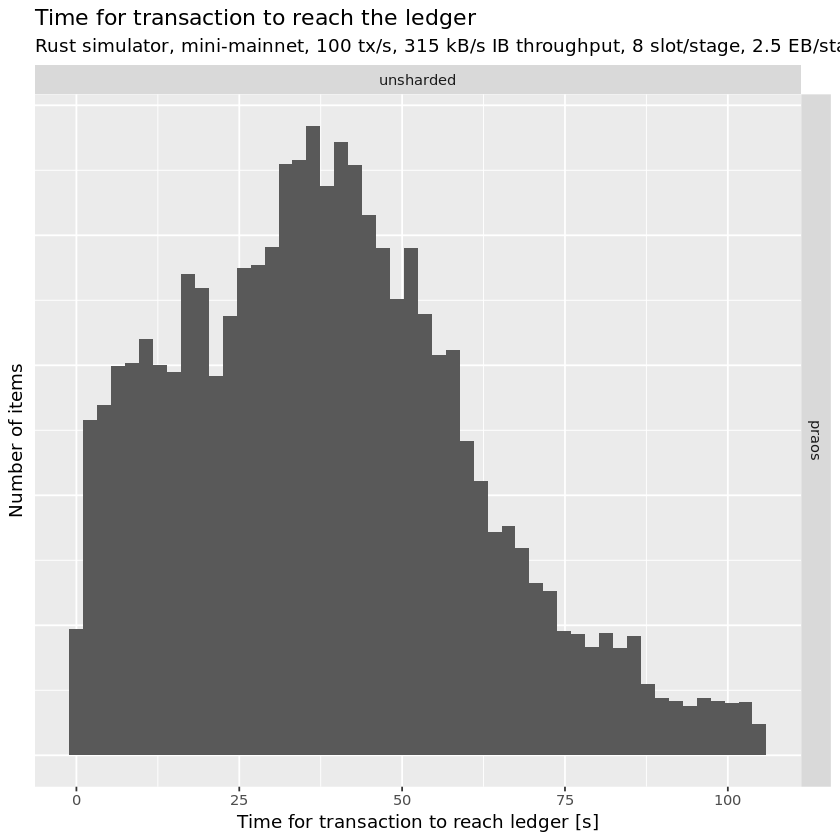

In [18]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`In RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`In RB [s]`-`Created [s]`), 
        .(`Kind`, `Variant`, `Sharding`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
#   scale_x_log10() +
    facet_grid(`Variant` ~ `Sharding`, scales="fixed") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [19]:
ggsave("plots/praos/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [20]:
ggsave("plots/praos/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [21]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [22]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Variant`, `Sharding`
    )
][order(`Variant`, `Sharding`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [23]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Variant`, `Sharding`, `Submitted [minute]`)]

#### Transactions reaching the ledger

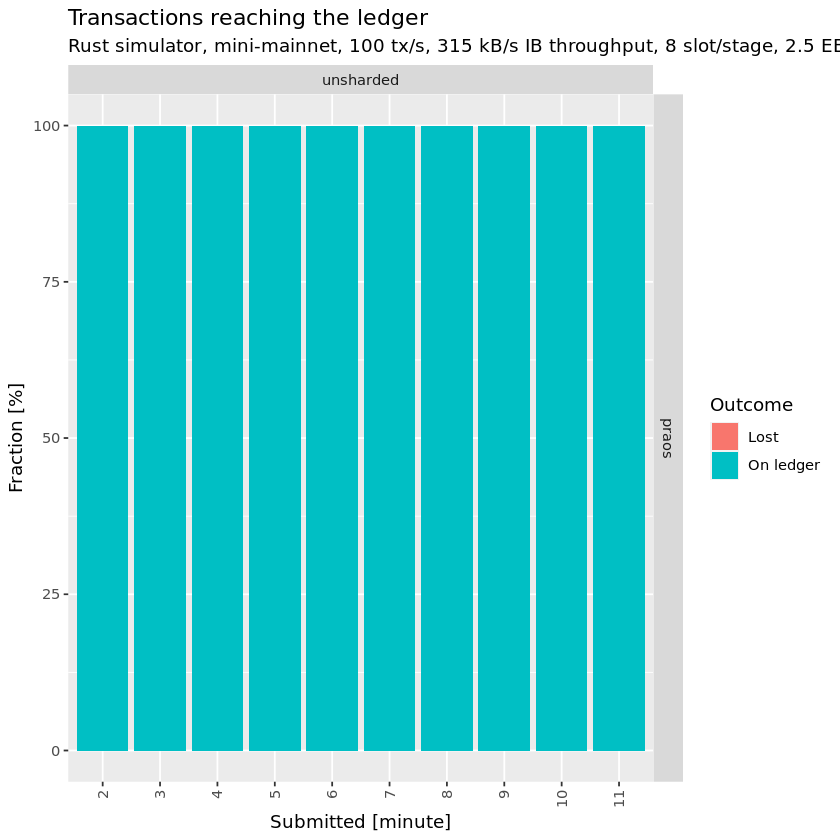

In [24]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Variant`, `Sharding`, `Submitted [minute]`)],
        id.vars=c("Variant", "Sharding", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Variant`, 
        `Sharding`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Variant` ~ `Sharding`) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [25]:
ggsave("plots/praos/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [26]:
ggsave("plots/praos/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

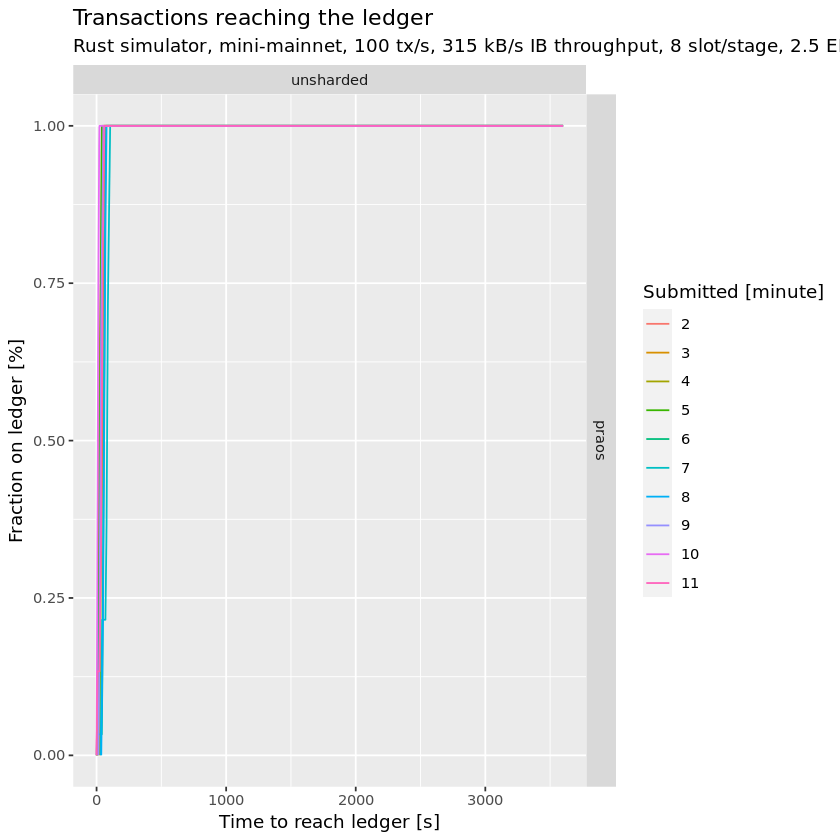

In [27]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Variant`, `Sharding`, `Submitted [minute]`)],
            on=c("Variant", "Sharding", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Variant`, `Sharding`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Variant`, `Sharding`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Variant` ~ `Sharding`) +
    ggtitle("Transactions reaching the ledger", label)

In [28]:
ggsave("plots/praos/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [29]:
ggsave("plots/praos/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [30]:
rm(lifecycle, outcomes, totals)

In [31]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,971304,51.9,2056688,109.9,2056688,109.9
Vcells,1991306,15.2,8425021,64.3,8425021,64.3


### Resource usage

In [32]:
if (file.exists("results/praos/resources.R")) {
    load(file="results/praos/resources.R")
} else {
    resources <- fread("results/praos/resources.csv.gz", stringsAsFactors=TRUE)
    save(resources, file="results/praos/resources.R")
}
resources %>% summary

 Simulator   Variant         Sharding         Node       Egress [B]       
 Rust:750   praos:750   unsharded:750   node-0  :  1   Min.   :0.000e+00  
                                        node-1  :  1   1st Qu.:1.254e+07  
                                        node-10 :  1   Median :1.883e+08  
                                        node-100:  1   Mean   :2.586e+08  
                                        node-101:  1   3rd Qu.:3.989e+08  
                                        node-102:  1   Max.   :2.173e+09  
                                        (Other) :744                      
    Disk [B]        Total CPU [s]   Maximum CPU [s/s]
 Min.   :       0   Min.   :160.1   Min.   :3.365    
 1st Qu.:       0   1st Qu.:169.8   1st Qu.:3.379    
 Median :       0   Median :171.3   Median :3.683    
 Mean   :  217072   Mean   :171.0   Mean   :4.188    
 3rd Qu.:       0   3rd Qu.:171.4   3rd Qu.:3.703    
 Max.   :16274066   Max.   :174.6   Max.   :6.915    
                      

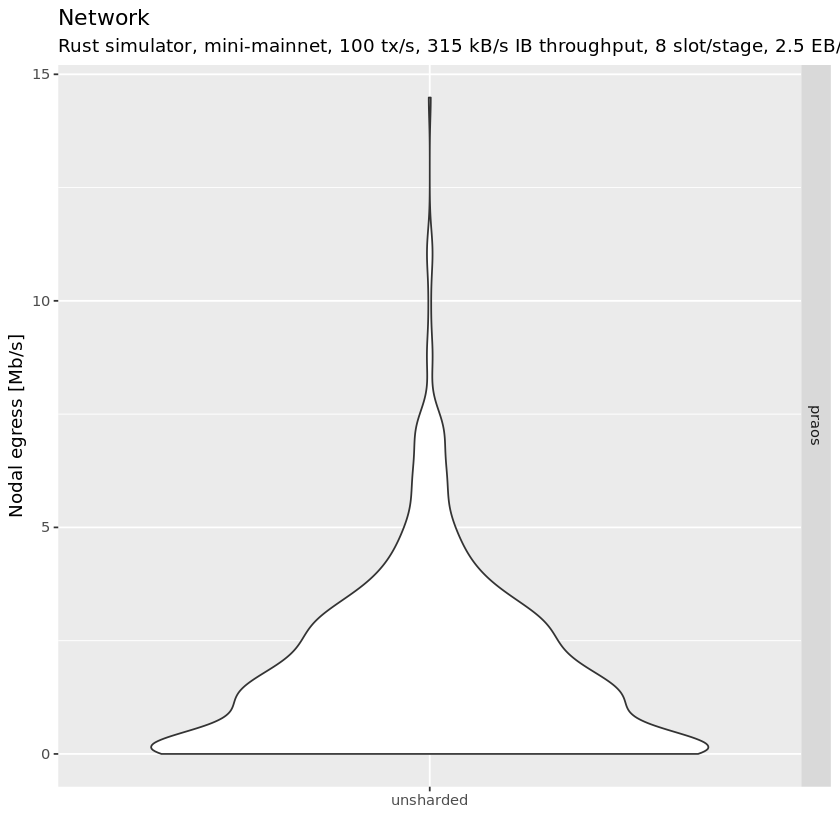

In [33]:
ggplot(
    resources[, .(`Variant`, `Sharding`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Sharding`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`Variant` ~ .) +
    xlab("") +
    ggtitle("Network", label)

In [34]:
ggsave("plots/praos/network.png", units="in", dpi=150, width=9.5, height=5.5)

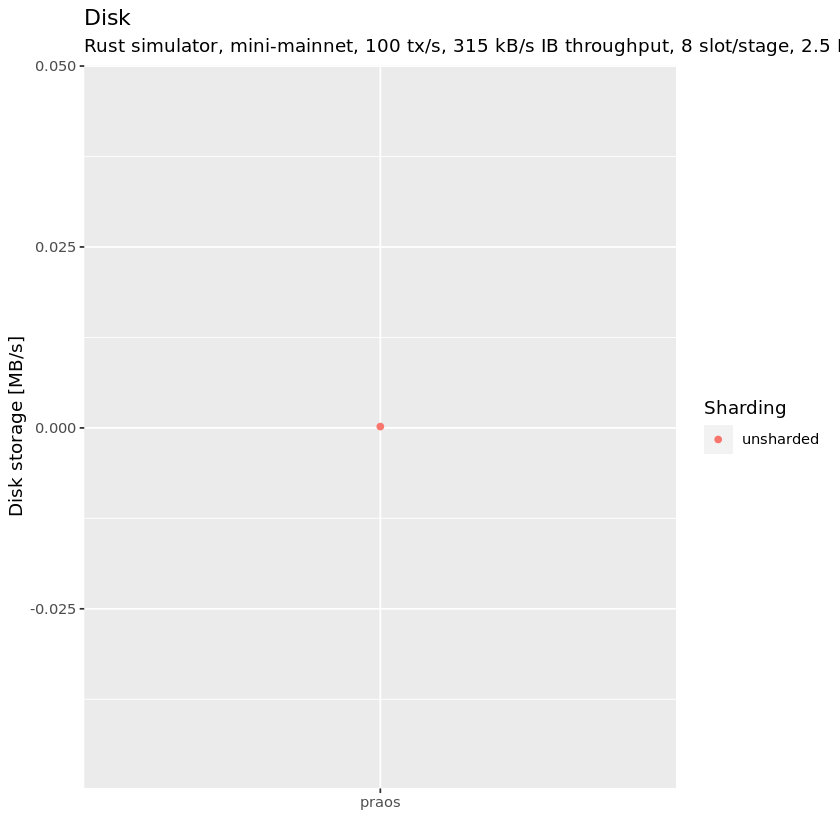

In [35]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Variant`, `Sharding`)],
    aes(x=`Variant`, color=`Sharding`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    xlab("") +
    ggtitle("Disk", label)

In [36]:
ggsave("plots/praos/disk.png", units="in", dpi=150, width=9.5, height=5.5)

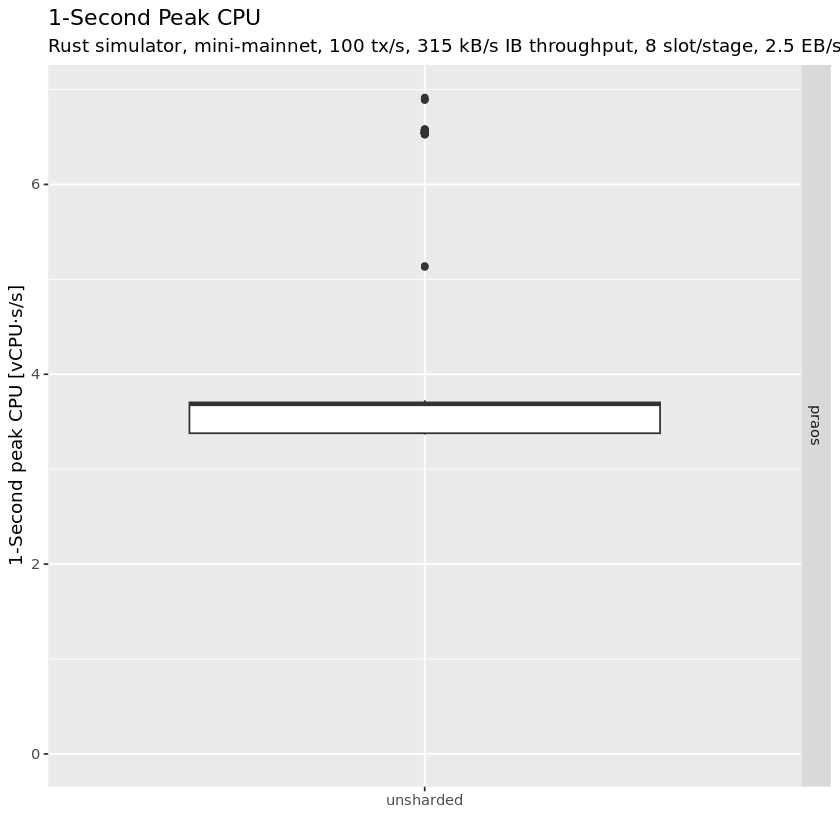

In [37]:
ggplot(
    resources[, .(`Node`, `Variant`, `Sharding`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Sharding`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Variant` ~ .) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [38]:
ggsave("plots/praos/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

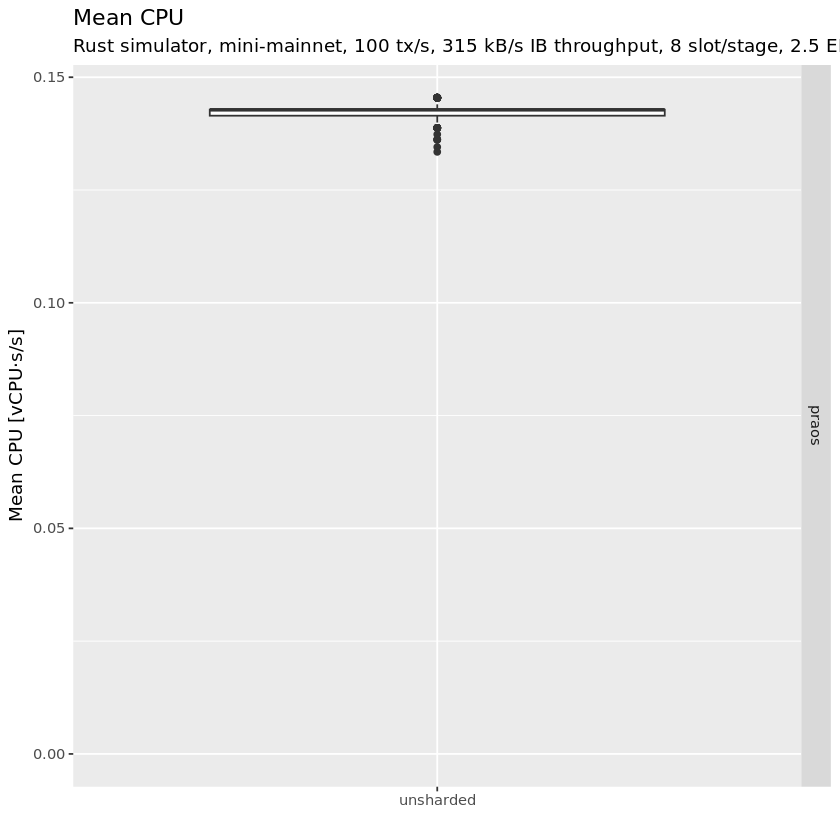

In [39]:
ggplot(
    resources[, .(`Variant`, `Sharding`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Sharding`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Variant` ~ .) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [40]:
ggsave("plots/praos/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [41]:
rm(resources)

In [42]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1001013,53.5,2056688,109.9,2056688,109.9
Vcells,1835215,14.1,8425021,64.3,8425021,64.3


### Receipt of messages

#### Read results

In [43]:
if (file.exists("results/praos/receipts.R")) {
    load("results/praos/receipts.R")
} else {
    receipts <- fread("results/praos/receipts.csv.gz", stringsAsFactors=TRUE)
    save(receipts, file="results/praos/receipts.R")
}
receipts %>% summary

 Simulator        Variant              Sharding        Kind         
 Rust:45132660   praos:45132660   unsharded:45132660   RB:   43609  
                                                       TX:45089051  
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
      Item              Producer        Generated [s]       Size [B]      
 0      :     749   node-505:  159537   Min.   :  20.0   Min.   :      8  
 1      :     749   node-303:  105609   1st Qu.: 209.9   1st Qu.:    438  
 10     :     749   node-314:  105609   Median : 359.1   Median :    935  
 100    :     749   node-474:  105609   Mean   : 359.9   Mean   :   4298  
 1000   :     749   node-420:  103362   3rd Qu.: 508.7   3rd Qu.:   2007 

In [44]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] RB TX
Levels: RB TX

#### Arrival histograms

##### Compare the distributions of elapsed times

In [45]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Variant`, `Sharding`, `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

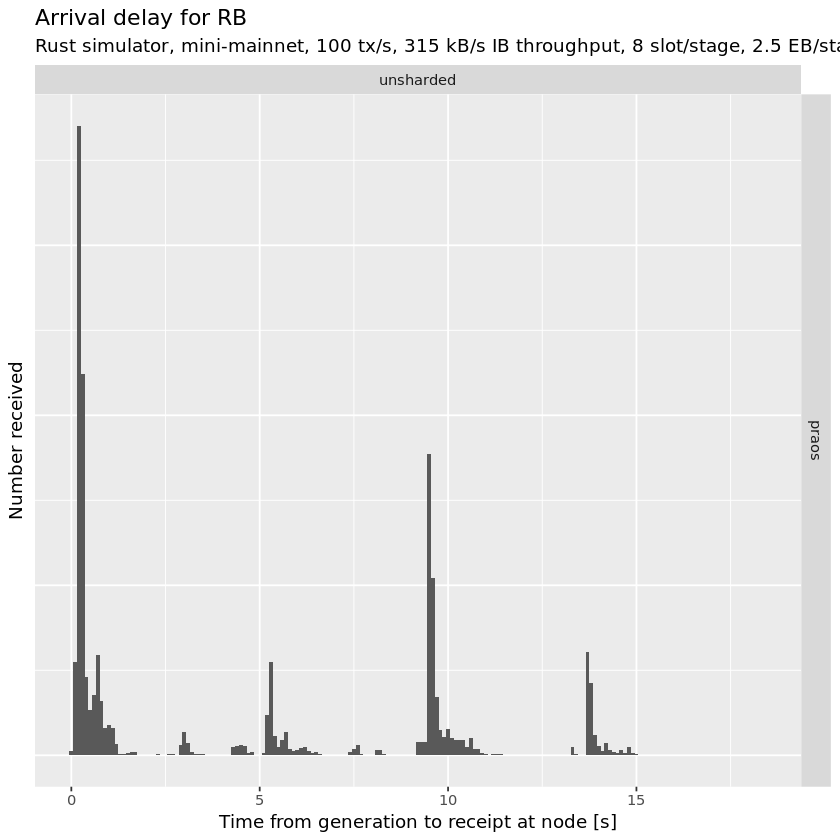

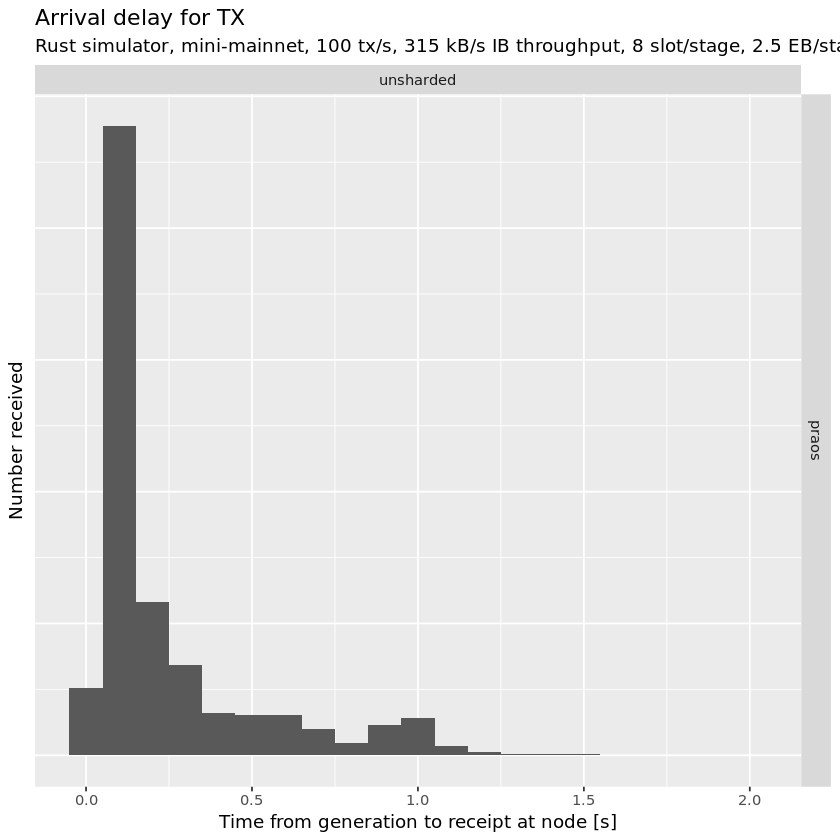

In [46]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/praos/elapsed-", k, ".png")
    ) %>% print

#### Diffusion time vs RB size

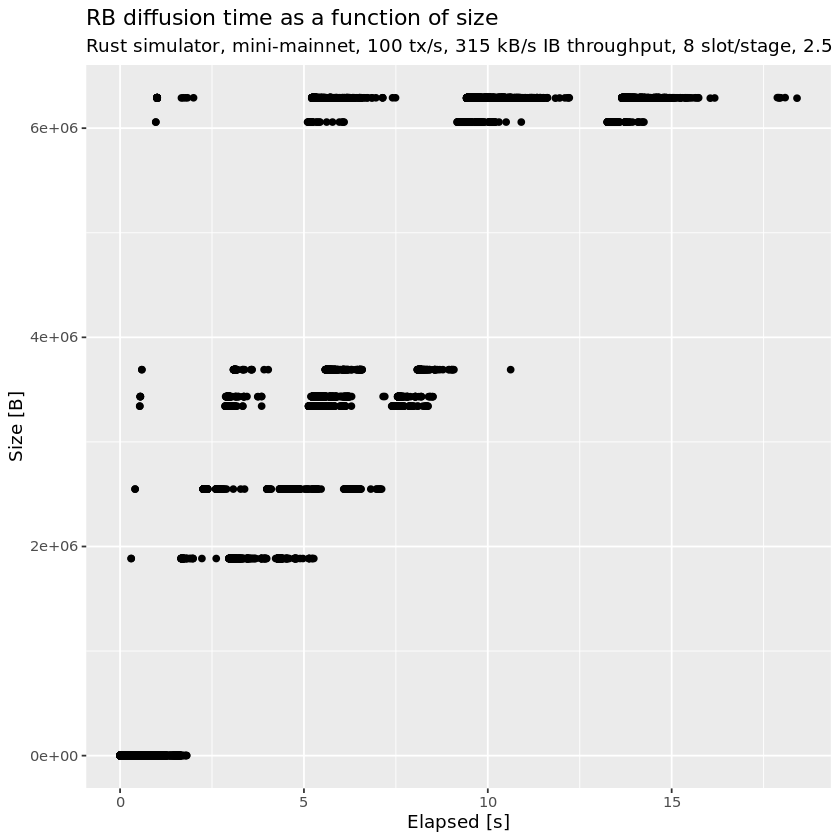

In [47]:
ggplot(receipts[`Kind` == "RB"], aes(y=`Size [B]`, x=`Elapsed [s]`)) +
    geom_point() +
    ggtitle("RB diffusion time as a function of size", subtitle=label)

In [48]:
ggsave("plots/praos/diffusion-size.png", units="in", dpi=150, width=8, height=6)

In [49]:
ggsave("plots/praos/diffusion-size.svg", units="in", dpi=150, width=8, height=6)

#### Fraction of items arriving

In [50]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Variant`, `Sharding`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Variant`, `Sharding`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Variant`, `Sharding`, `Generated [s]`)
        ][, .(`Variant`, `Sharding`, `Generated [s]`,`Received`)
        ], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Variant`  ~ `Sharding`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

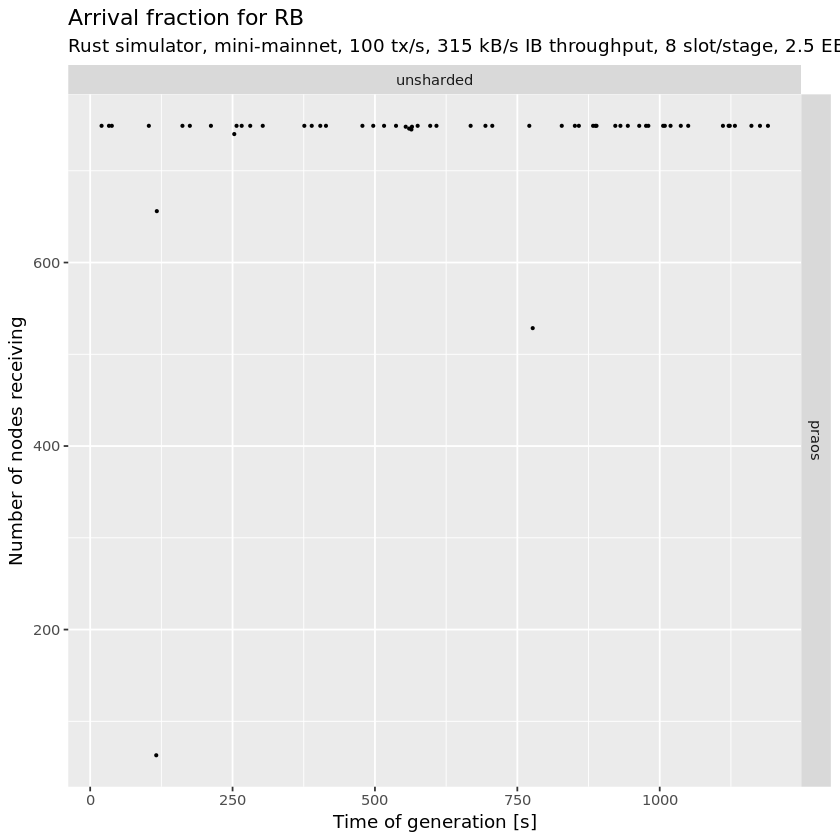

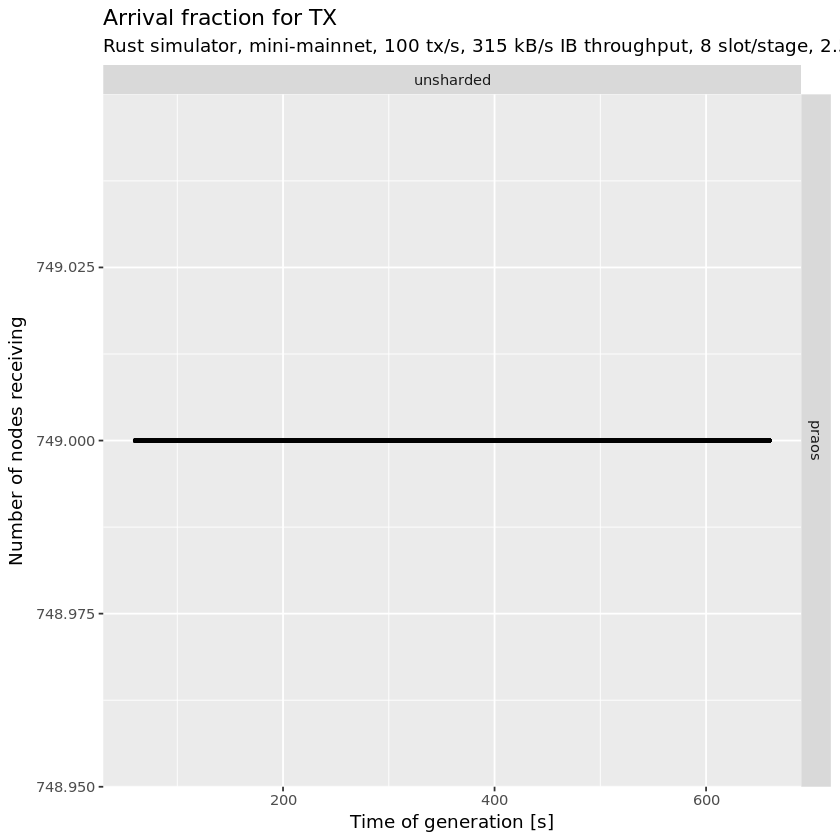

In [51]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/praos/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [52]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Variant`,
                `Sharding`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

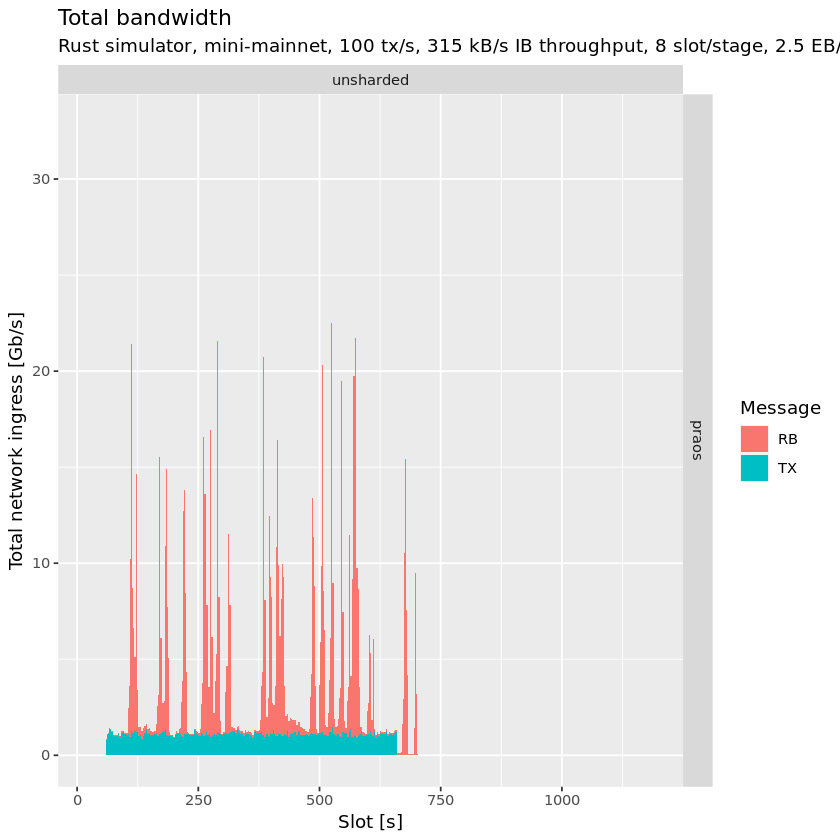

In [53]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/praos/ingress-total-area.png")
)

##### Bandwidth usage per node

In [54]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [55]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Variant`,
                `Sharding`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

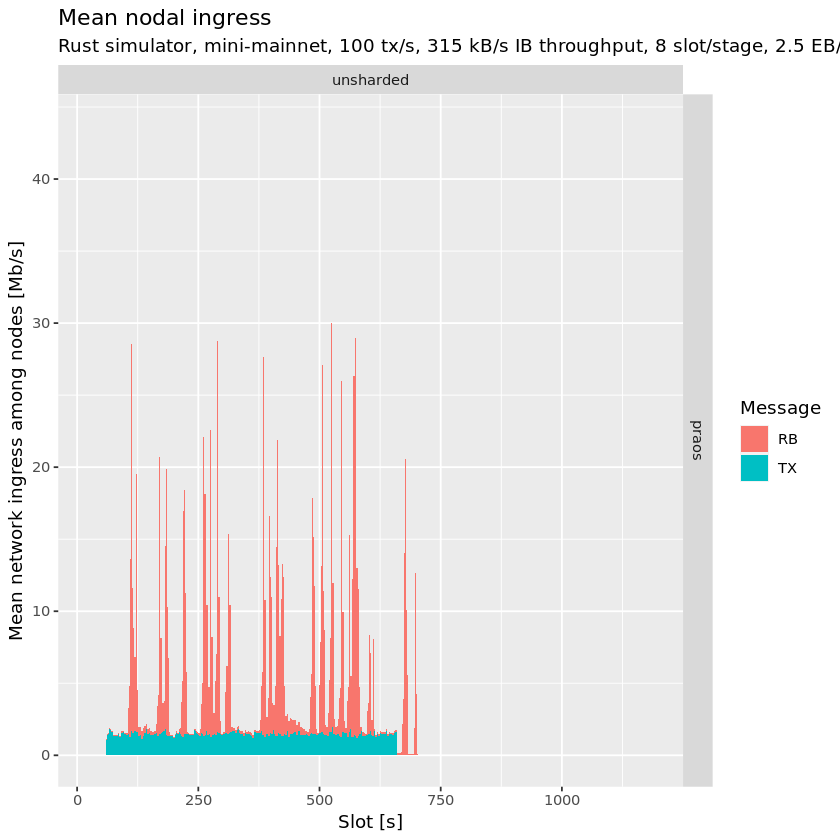

In [56]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/praos/ingress-average-area.png")
)

In [57]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Variant`,
                `Sharding`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Variant`, `Sharding`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

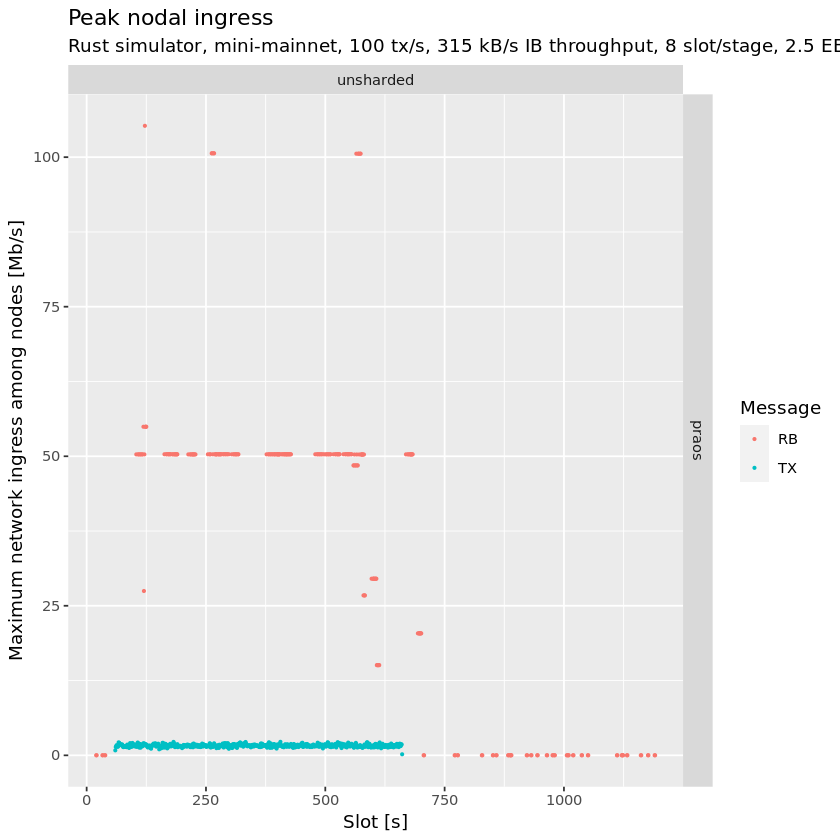

In [58]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/praos/ingress-peak-point.png")
)

#### Release memory

In [59]:
rm(receipts)

In [60]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1071483,57.3,2056688,109.9,2056688,109.9
Vcells,340485691,2597.7,1318508163,10059.5,1648135203,12574.3


### CPU usage

#### Read results

In [61]:
if (file.exists("results/praos/cpus.R")) {
    load(file="results/praos/cpus.R")
} else {
    cpus <- fread("results/praos/cpus.csv.gz", stringsAsFactors=TRUE)
    save(cpus, file="results/praos/cpus.R")
}
cpus %>% summary

 Simulator        Variant              Sharding             Slot       
 Rust:45132720   praos:45132720   unsharded:45132720   Min.   :  20.0  
                                                       1st Qu.: 210.0  
                                                       Median : 359.0  
                                                       Mean   : 359.6  
                                                       3rd Qu.: 508.0  
                                                       Max.   :1191.0  
                                                                       
       Node             Task           Duration [s]     
 node-141:   60258   GenRB:      60   Min.   :0.001000  
 node-155:   60258   ValRB:   43609   1st Qu.:0.001500  
 node-165:   60258   ValTX:45089051   Median :0.001500  
 node-183:   60258                    Mean   :0.002842  
 node-186:   60258                    3rd Qu.:0.001500  
 node-193:   60258                    Max.   :3.196553  
 (Other) :44771172       

In [62]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Variant`, `Sharding`, `Node`, `Slot`)
]

In [63]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [64]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Variant`, `Sharding`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

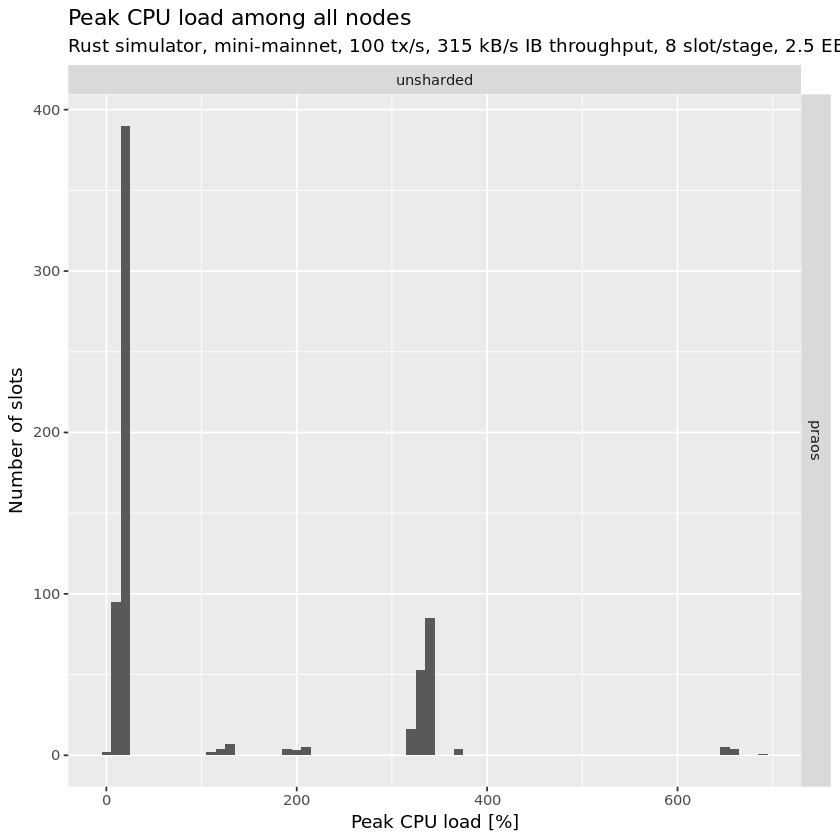

In [65]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/praos/cpu-peak-histogram.png")
)

##### Time series

In [66]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)),
            by=.(`Variant`, `Sharding`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Variant` ~ `Sharding`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

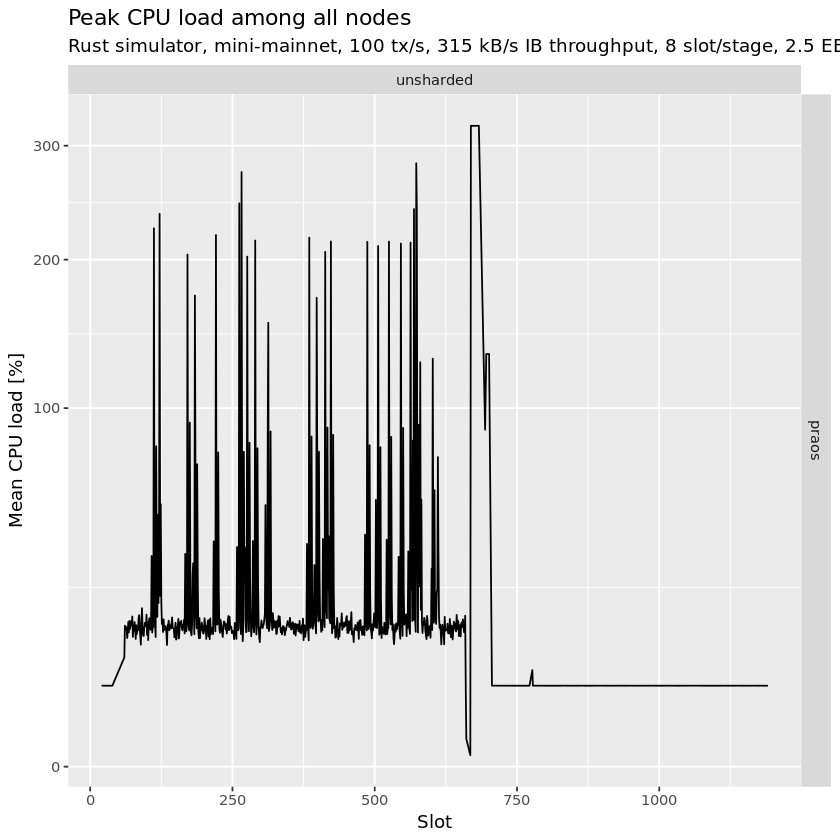

In [67]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/praos/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [68]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Sharding`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

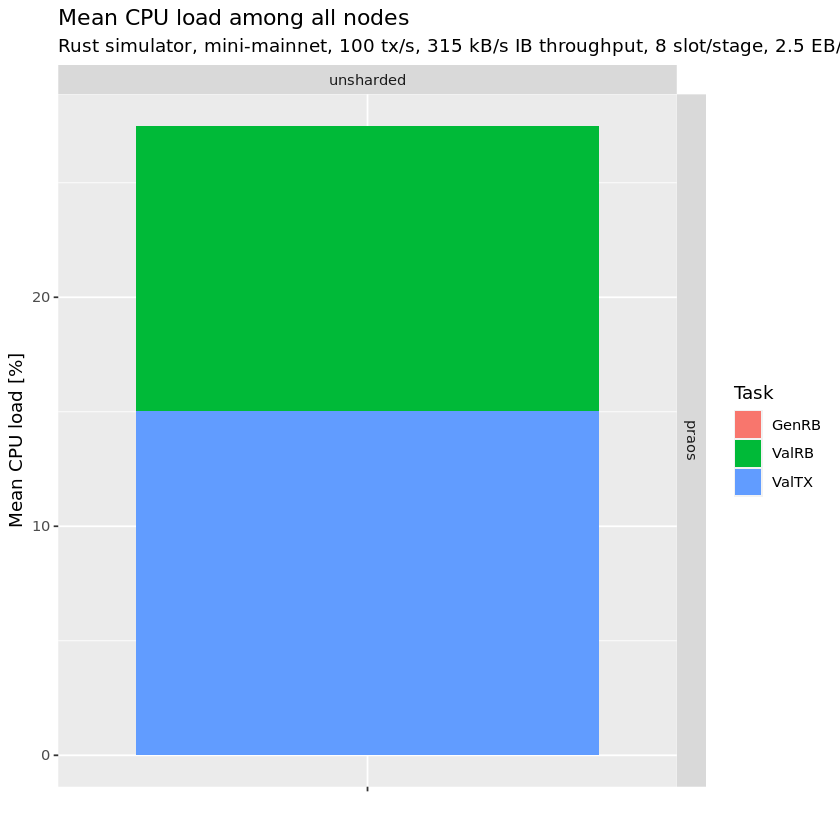

In [69]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/praos/cpu-mean-histogram.png")
)

##### Time series

In [70]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Sharding`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Variant` ~ `Sharding`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

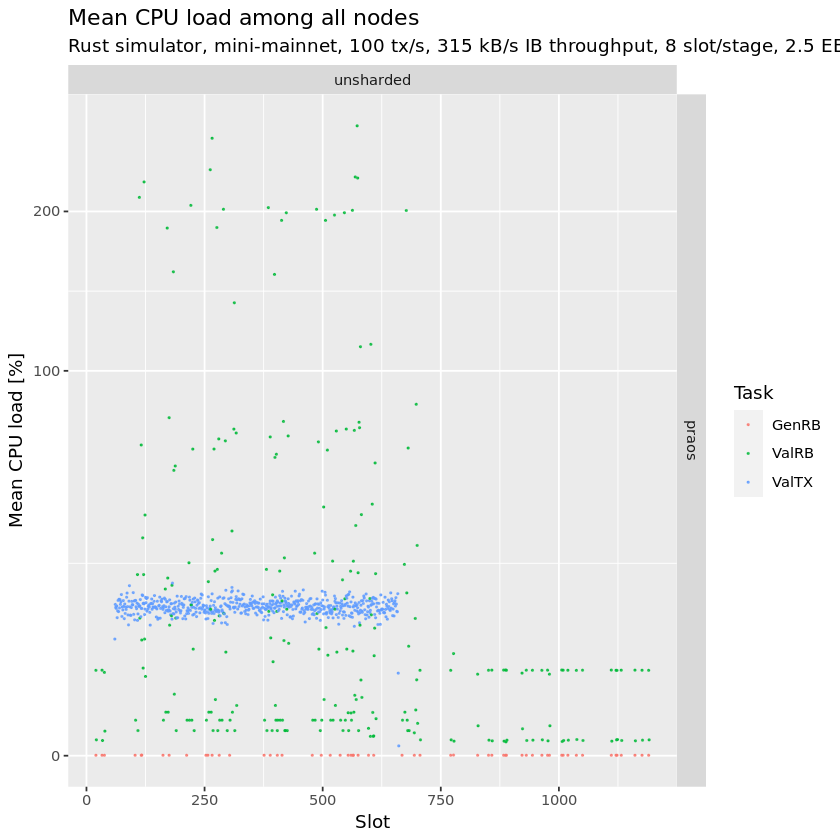

In [71]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/praos/cpu-mean-timeseries.png")
)

#### Release memory

In [72]:
rm(cpus, cpusNode)

In [73]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1014094,54.2,2056688,109.9,2056688,109.9
Vcells,182398063,1391.6,1054806531,8047.6,1648135203,12574.3
